In [1]:
#Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

#Math and Vectors
import pandas as pd
import numpy as np
import random

#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

#Dataset importation
from sklearn import datasets

In [2]:
class NeuralNetwork:
    def __init__(self, input_layer: int, first_hidden_layer: int,
                 second_hidden_layer: int, output: int):

        # Metrics
        self.losses_list = []
        self.accuracy_list = []
        self.target_dict = {
            0: "setosa",
            1: "versicolor",
            2: "virginica"
        }

        self.__INPUT = input_layer
        self.__HIDDEN_ONE = first_hidden_layer
        self.__HIDDEN_TWO = second_hidden_layer
        self.__OUTPUT = output

        # Layers
        self.__input_hidden = np.random.randn(self.__INPUT, self.__HIDDEN_ONE)
        self.__input_bias = np.random.randn(1, self.__HIDDEN_ONE)
        self.__hidden_hidden = np.random.randn(self.__HIDDEN_ONE, self.__HIDDEN_TWO)
        self.__hidden_bias_1 = np.random.randn(1, self.__HIDDEN_TWO)
        self.__hidden_output = np.random.randn(self.__HIDDEN_TWO, self.__OUTPUT)
        self.__hidden_bias_2 = np.random.randn(1, self.__OUTPUT)

    @staticmethod
    def __relu(x):
        return 0 if x <= 0 else x

    @staticmethod
    def __derive_relu(y):
        return 0 if y <= 0 else 1

    @staticmethod
    def __sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @classmethod
    def __derive_sigmoid(cls, y):
        return cls.__sigmoid(y) * (1 - cls.__sigmoid(y))

    @staticmethod
    def __hyperbolic_tangent(num):
        return (np.exp(num) - np.exp(-num)) / (np.exp(num) + np.exp(-num))

    @classmethod
    def __derive_hyperbolic_tangent(cls, num):
        return 1 - cls.__hyperbolic_tangent(num) ** 2

    @staticmethod
    def __leaky_relu(num, angle: float = 0.01):
        return num * angle if num < 0 else num

    @staticmethod
    def __derive_leaky_relu(num, angle: float = 0.01):
        return angle if num < 0 else 1

    @staticmethod
    def __softplus(num):
        return np.log(1 + np.exp(num))

    @staticmethod
    def __derive_softplus(num):
        return 1 / 1 + np.exp(-num)

    @staticmethod
    def __softmax(weighted_sum):
        out = np.exp(weighted_sum)
        return out / np.sum(out)

    @staticmethod
    def softmax_batch(t):
        out = np.exp(t)
        return out / np.sum(out, axis=1, keepdims=True)

    @staticmethod
    def sparse_cross_entropy(z, y):
        return -np.log(z[0, y])

    @staticmethod
    def sparse_cross_entropy_batch(z, y):
        return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

    @staticmethod
    def __one_hot_encoding(correct_index, num_classes):
        y_full = np.zeros((1, num_classes))
        y_full[0, correct_index] = 1
        return y_full

    def __one_hot_encoding_batch(y, num_classes):
        y_full = np.zeros((len(y), num_classes))
        for j, yj in enumerate(y):
            y_full[j, yj] = 1
        return y_full

    @classmethod
    def __activate_dictionary(cls):
        return {
            'relu': [cls.__relu, cls.__derive_relu],
            'sigmoid': [cls.__sigmoid, cls.__derive_sigmoid],
            'hyper_tan': [cls.__hyperbolic_tangent, cls.__derive_hyperbolic_tangent],
            'leaky_relu': [cls.__leaky_relu, cls.__derive_leaky_relu],
            'softplus': [cls.__softplus, cls.__derive_softplus]
        }

    def get_functions(self):
        return self.__activate_dictionary().keys()

    def __forward(self, batch_x, batch_y=None, epoch=None, iters=None, training=False):
        # Forward pass
        activation_function = self.__activate_dictionary().get(self.__activation_function)[0]
        weighted_sum_1 = batch_x @ self.__input_hidden + self.__input_bias
        
        activation_1 = np.array(list(map(activation_function, weighted_sum_1.ravel())))
        weighted_sum_2 = activation_1 @ self.__hidden_hidden + self.__hidden_bias_1
        
        activation_2 = np.array(list(map(activation_function, weighted_sum_2.ravel())))
        weighted_sum_3 = activation_2 @ self.__hidden_output + self.__hidden_bias_2
        predict = self.__softmax(weighted_sum_3)
        if not training:
            return predict
        
        # Error Indexing
        loss = self.sparse_cross_entropy(predict, batch_y)
        self.losses_list.append(loss)

        # Output Information
        if iters % 15 == 0 and epoch != 0:
            print(f"==> Epoch ~ [ {epoch} ] || Loses ~ [ {loss} ]",
                  f" Accuracy ~ [ {self.accuracy_list[-1]} ]")

        # Updating Graph Edges
        self.__dict__.update(
            {
                f"_{type(self).__name__}__weighted_sum_1": weighted_sum_1,
                f"_{type(self).__name__}__activation_1": activation_1,
                f"_{type(self).__name__}__weighted_sum_2": weighted_sum_2,
                f"_{type(self).__name__}__activation_2": activation_2,
                f"_{type(self).__name__}__weighted_sum_3": weighted_sum_3,
                f"_{type(self).__name__}__predict": predict
            }
        )

    def __backward(self, data_x, truth_y):
        # Backpropagation
        activation_function = self.__activate_dictionary().get(self.__activation_function)[1]
        y_full = self.__one_hot_encoding(truth_y, self.__OUTPUT)
        
        weighted_sum_3_grad = self.__predict - y_full
        hidden_output_grad = np.expand_dims(self.__activation_2, axis=0).T @ weighted_sum_3_grad
        hidden_bias_2_grad = weighted_sum_3_grad
        
        activation_2_grad = weighted_sum_3_grad @ self.__hidden_output.T
        
        weighted_sum_2_grad = activation_2_grad * np.array(
            list(map(activation_function, self.__weighted_sum_2.ravel())))
        
        hidden_hidden_grad = np.expand_dims(self.__activation_1, axis=0).T @ weighted_sum_2_grad
        hidden_bias_1_grad = weighted_sum_2_grad
        activation_1_grad = weighted_sum_2_grad @ self.__hidden_hidden
        
        weighted_sum_1_grad = activation_1_grad * np.array(
            list(map(activation_function, self.__weighted_sum_1.ravel())))
        
        input_hidden_grad = data_x.T @ weighted_sum_1_grad
        input_bias_grad = weighted_sum_1_grad

        # Gradients updating
        self.__dict__.update({
           f"_{type(self).__name__}__hidden_output_grad": hidden_output_grad,
           f"_{type(self).__name__}__hidden_bias_2_grad": hidden_bias_2_grad,
           f"_{type(self).__name__}__hidden_hidden_grad": hidden_hidden_grad,
           f"_{type(self).__name__}__hidden_bias_1_grad": hidden_bias_1_grad,
           f"_{type(self).__name__}__input_hidden_grad": input_hidden_grad,
           f"_{type(self).__name__}__input_bias_grad": input_bias_grad
           })

    def __update(self, alpha):
        self.__input_hidden -= self.__input_hidden_grad * alpha
        self.__input_bias -= self.__input_bias_grad * alpha
        self.__hidden_hidden -= self.__hidden_hidden_grad * alpha
        self.__hidden_bias_1 -= self.__hidden_bias_1_grad * alpha
        self.__hidden_output -= self.__hidden_output_grad * alpha
        self.__hidden_bias_2 -= self.__hidden_bias_2_grad * alpha

    def __accuracy_calculation(self, tests_dataset, truth_y, epoch, iters):
        correct = 0
        for x, y in tests_dataset:
            self.__forward(x, truth_y, epoch, iters, training=True)
            predict = np.argmax(self.__predict)
            if predict == y:
                correct += 1
        accuracy = correct / len(tests_dataset)
        self.accuracy_list.append(accuracy)

    def compile(self, optimizer: str = "stochastic", activation_function: str = "relu"):
        self.__dict__.update({f"_{type(self).__name__}__optimizer": optimizer,
                              f"_{type(self).__name__}__activation_function": activation_function})

    def fit(self, epochs: int, fit_dataset, tests_dataset, alpha: float = 0.01):
        for epoch in range(epochs):
            random.shuffle(fit_dataset)
            for iters in range(len(fit_dataset)):
                data_x, truth_y = fit_dataset[iters]
                self.__forward(data_x, truth_y, epoch, iters, training=True)
                self.__backward(data_x, truth_y)
                self.__update(alpha)
            self.__accuracy_calculation(tests_dataset, truth_y, epoch, iters)
            
    def __call__(self, x):
        outputs = self.__forward(x, training=False)
        predict = np.argmax(outputs)
        label = self.target_dict[np.argmax(outputs)]
        return predict, label

## Training

In [3]:
iris = datasets.load_iris()
dataset = [(iris.data[i][None, ...], iris.target[i]) for i in range(len(iris.target))]
random.shuffle(dataset)  # Dataset | 150
train_dataset = dataset[0:100]  # Learning | 100
test_dataset = dataset[100:150]  # Testing | 50

==> Epoch ~ [ 1 ] || Loses ~ [ 1.0748324065889048 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 1 ] || Loses ~ [ 0.880813036345717 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 1 ] || Loses ~ [ 1.2151593095872617 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 1 ] || Loses ~ [ 1.0444697270592886 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 1 ] || Loses ~ [ 0.8394355743779189 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 1 ] || Loses ~ [ 1.1724222681640408 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 1 ] || Loses ~ [ 1.3166142215154384 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 1.120642363539743 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 1.2376450081450938 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 0.7949516831891005 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 0.9947157718709585 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 1.1754873933657108 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 1.1868126086327164 ]  Accuracy ~ [ 0.32 ]
==> Epoch ~ [ 2 ] || Loses ~ [ 1.0137314478766946 ]  

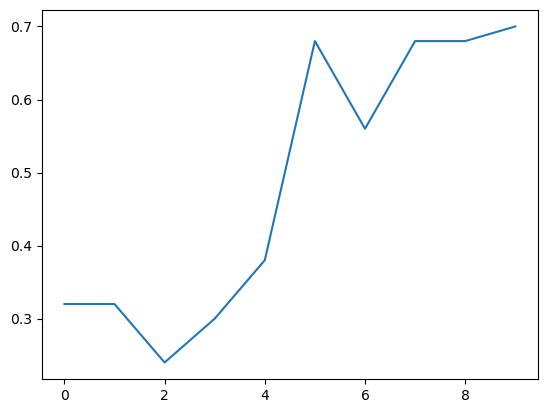

In [4]:
model = NeuralNetwork(
    input_layer=4,
    first_hidden_layer=8,
    second_hidden_layer=8,
    output=3
)

model.compile(optimizer="stochastic", activation_function="sigmoid")
model.fit(epochs=10, alpha=0.05, fit_dataset=train_dataset, tests_dataset=test_dataset)

plt.plot(model.accuracy_list)
plt.show()

In [5]:
def roll_predict(data: list, start: int = 0, end: int = 10) -> None:
    for x, label in data[start:end]:
        label = model.target_dict[label]
        predict, output = model(x)
        color = Fore.GREEN if label == output else Fore.RED 
        print(f"{color}Predicted: {output} || Ground truth: {label}")

In [6]:
roll_predict(test_dataset, end = 20)

Predicted: setosa || Ground truth: setosa
Predicted: versicolor || Ground truth: versicolor
Predicted: setosa || Ground truth: setosa
Predicted: versicolor || Ground truth: virginica
Predicted: versicolor || Ground truth: virginica
Predicted: versicolor || Ground truth: virginica
Predicted: setosa || Ground truth: setosa
Predicted: versicolor || Ground truth: versicolor
Predicted: setosa || Ground truth: setosa
Predicted: setosa || Ground truth: setosa
Predicted: versicolor || Ground truth: versicolor
Predicted: versicolor || Ground truth: virginica
Predicted: versicolor || Ground truth: versicolor
Predicted: versicolor || Ground truth: versicolor
Predicted: versicolor || Ground truth: versicolor
Predicted: versicolor || Ground truth: virginica
Predicted: versicolor || Ground truth: virginica
Predicted: versicolor || Ground truth: virginica
Predicted: versicolor || Ground truth: versicolor
Predicted: versicolor || Ground truth: virginica
